In [2]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
import math

In [3]:
psi = np.load(r"C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy")

### PreProcess data
Loaded in as "psi" from personal directory.

In [4]:
# Pre-processing

lead = 1

trainN = 200000
valN = 50000
index = 63

psi = psi[:,1,:]

print(psi.shape)
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi

psi_train_input = torch.tensor(psi[0:trainN,:])
psi_train_label =  torch.tensor(psi[lead:trainN+lead,:])

psi_val_input = torch.tensor(psi[trainN:trainN+valN,:])
psi_val_label =  torch.tensor(psi[trainN+lead:trainN+valN+lead,:])

print(psi_train_input.shape)
print(psi_train_label.shape)
print(psi_val_input.shape)
print(psi_val_label.shape)

(309700, 75)
torch.Size([200000, 75])
torch.Size([200000, 75])
torch.Size([50000, 75])
torch.Size([50000, 75])


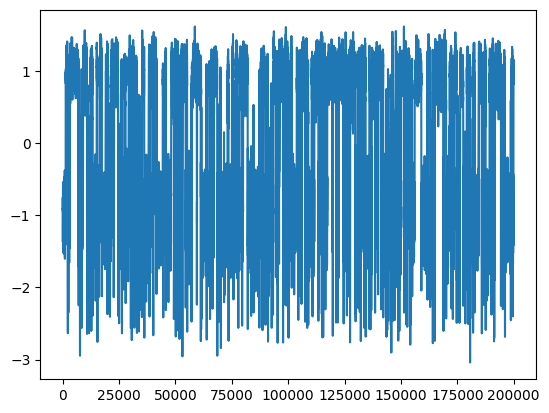

In [5]:
plt.plot(psi_train_input[0:200000,63])

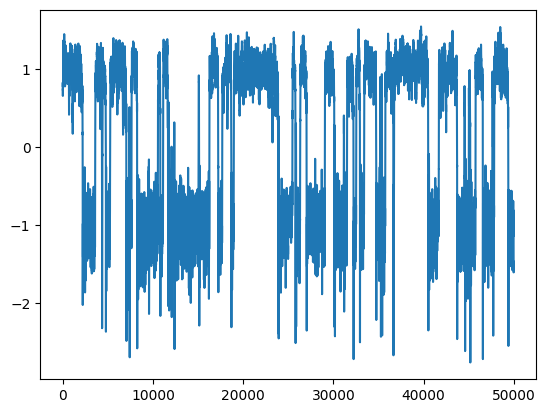

In [6]:
plt.plot(psi_val_input[0:200000,63])

### Define Model Architecture

In [7]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(75, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_mu = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Latent space (2)
        self.fc_logvar = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Log variance (2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(512, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar

input_dim = 1
output_dim = 75
latent_dim = 1024
condition_dim = 75
batch_size = 1024
num_epochs = 10

### Initialize Model and Set Folder Path

In [10]:
import datetime
import os


# Initialize the model, optimizer, and loss function
model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"model_at_{timestamp}"
model_weights_path = f'{folder}/model_weights_pytorch.pth'
os.makedirs(folder)

# Train the Model
Make sure to set the configurations if you want to use TVD and CCDF metrics.

Reference Real Data average_transition_time: 757.1306532663317
Epoch 1, 
          Reconstrunction Loss: 303.82257080078125,
          KL Divergence Loss: 15.145315170288086

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [27:07<00:00, 184.32it/s]


No transitions detected in predictions.
Epoch 2, 
          Reconstrunction Loss: 289.61029052734375,
          KL Divergence Loss: 13.413679122924805

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [26:42<00:00, 187.22it/s]


No transitions detected in predictions.
Epoch 3, 
          Reconstrunction Loss: 290.2610778808594,
          KL Divergence Loss: 11.682219505310059

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [26:59<00:00, 185.21it/s]


No transitions detected in predictions.
Epoch 4, 
          Reconstrunction Loss: 283.40277099609375,
          KL Divergence Loss: 10.915325164794922

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [26:39<00:00, 187.61it/s]


No transitions detected in predictions.
Epoch 5, 
          Reconstrunction Loss: 272.40093994140625,
          KL Divergence Loss: 10.225764274597168

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [26:31<00:00, 188.52it/s]


No transitions detected in predictions.
Epoch 6, 
          Reconstrunction Loss: 267.20159912109375,
          KL Divergence Loss: 9.700443267822266

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [26:31<00:00, 188.50it/s]


No transitions detected in predictions.
Epoch 7, 
          Reconstrunction Loss: 258.918212890625,
          KL Divergence Loss: 8.556462287902832

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [26:43<00:00, 187.10it/s]


No transitions detected in predictions.
Epoch 8, 
          Reconstrunction Loss: 255.6405487060547,
          KL Divergence Loss: 8.505633354187012

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [26:48<00:00, 186.46it/s]


No transitions detected in predictions.
Epoch 9, 
          Reconstrunction Loss: 230.67510986328125,
          KL Divergence Loss: 8.196528434753418

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [27:04<00:00, 184.62it/s]


No transitions detected in predictions.
Epoch 10, 
          Reconstrunction Loss: 248.27761840820312,
          KL Divergence Loss: 6.549963474273682

Starting inference for CCDF and TVD evaluation...


Inference per Time Step with Ensemble Averaging: 100%|██████████| 300000/300000 [26:13<00:00, 190.61it/s]


No transitions detected in predictions.


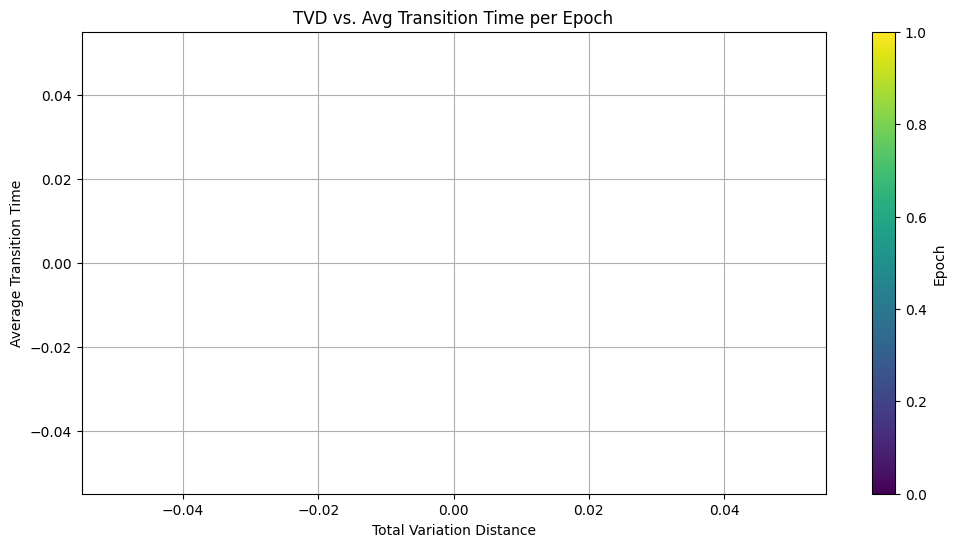

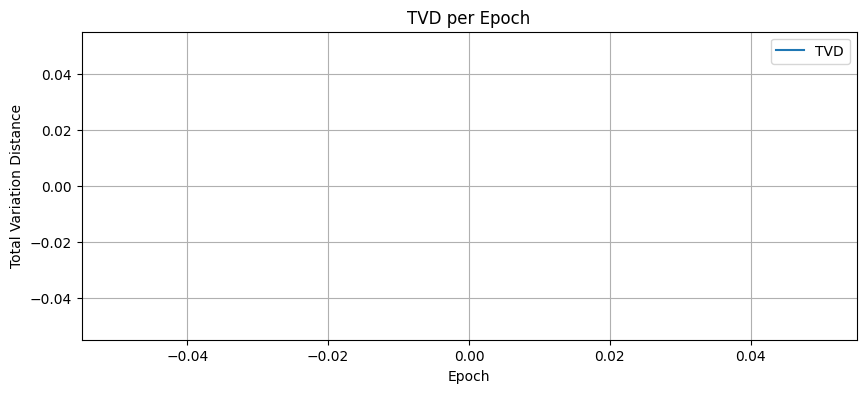

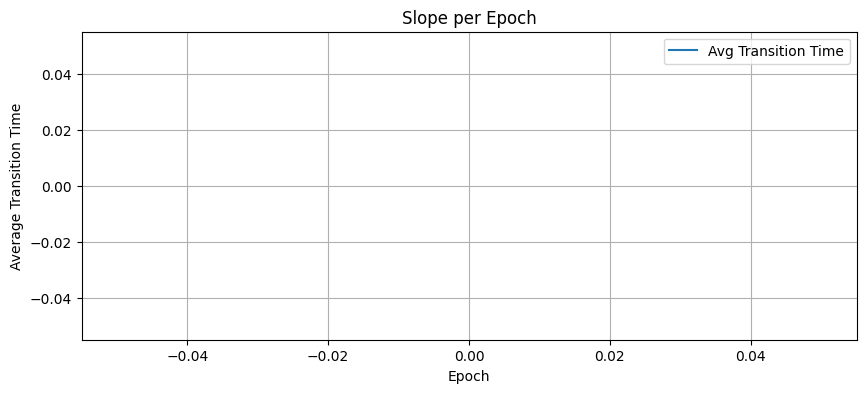

: 

In [ ]:
# summary(model, input_size = [(128, 1, 75), (128, 75)])
#=====CONFIGURATION======#
#f(Ac)/f(A^*)=f(Bc)/f(B^*)
USE_METRICS = 1
CCDF_LEVEL = 63
UPPER_BOUND = 53.8 / 2.8935
LOWER_BOUND = 1.75 / 2.8935
num_ens = 10
best_distance = float('inf')
tvd_list = []
slope_list = []
slope_list_unormalized = []
real_data = np.load(r"C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy")

def normalize_transition_time(slope_value, delta, slope_real):
    normalized = 1 - np.exp(-np.abs((slope_value - slope_real)) / delta)
    return normalized

def total_variation_distance(p, q):
    p = np.array(p)
    q = np.array(q)
    return 0.5 * np.sum(np.abs(p - q))

actual_hist, bin_edges = np.histogram(real_data[:, 1, CCDF_LEVEL], bins=50, density=True)


def calculate_transition_durations(y_values, upper_bound, lower_bound):
    times_between_transitions = []
    transition_start = None
    above_upper = False
    below_lower = False
    for i in range(1, len(y_values)):
        if y_values[i] < lower_bound:
            below_lower = True
            above_upper = False
        elif y_values[i] > upper_bound:
            if below_lower and transition_start is not None:
                times_between_transitions.append(i - transition_start)
                transition_start = None
            above_upper = True
            below_lower = False
        if below_lower and transition_start is None:
            transition_start = i
    return times_between_transitions

real_data_1d = real_data[:, 1, CCDF_LEVEL]
real_durations = calculate_transition_durations(real_data_1d, UPPER_BOUND, LOWER_BOUND)
real_data_sorted = np.sort(real_durations)
slope_real = np.mean(real_data_sorted)
print(f"Reference Real Data average_transition_time: {slope_real}")

for epoch in range(num_epochs):
    model.train()
    for batch in range(0, trainN, batch_size):
        input_batch = psi_train_input[batch:batch + batch_size, :]
        label_batch = psi_train_label[batch:batch + batch_size, :]

        optimizer.zero_grad()

        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda())
        reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        loss = reconstruction_loss + 10 * kl_loss

        loss.backward()
        optimizer.step()

    print(f"""Epoch {epoch+1}, 
          Reconstrunction Loss: {reconstruction_loss},
          KL Divergence Loss: {kl_loss}""")

    if USE_METRICS:
        print("\nStarting inference for CCDF and TVD evaluation...")

        inference_steps = 300000
        pred = np.zeros((inference_steps, 75, 1))

        model.eval()
    with torch.no_grad():
        initial_cond = torch.reshape(torch.tensor(psi[0, :]), [1, 75]).float().cuda()
        current_input = initial_cond.clone()

        pred = np.zeros((inference_steps, 75))  # Only store averaged prediction per step

        for k in tqdm(range(inference_steps), desc=f"Inference per Time Step with Ensemble Averaging"):
            ensemble_outputs = []

            for ens in range(num_ens):
                z = torch.randn(1, latent_dim).cuda()

                y = model.decode(z, current_input).float().detach().cpu().numpy()
                ensemble_outputs.append(y)

            y_avg = np.mean(np.array(ensemble_outputs), axis=0)  # shape: (1, 75)
            pred[k, :] = y_avg

            y_denorm = y_avg * std_psi[:, :] + mean_psi[:, :]
            current_input = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :], dtype=torch.float32).cuda()


    pred_mean = pred * std_psi + mean_psi  # shape: (inference_steps, 75)
    pred_mean = pred_mean.reshape(inference_steps, 75, 1)


    predictions_1d = pred_mean[:, CCDF_LEVEL, 0]
    pred_durations = calculate_transition_durations(predictions_1d, UPPER_BOUND, LOWER_BOUND)
    pred_hist, _ = np.histogram(predictions_1d, bins=bin_edges, density=True)

    if len(pred_durations) > 0:
        slope_pred = np.mean(pred_durations)
        slope_list.append(normalize_transition_time(slope_pred, 1000, slope_real))
        slope_list_unormalized.append(slope_pred)
        tvd = total_variation_distance(pred_hist, actual_hist)
        tvd_list.append(tvd)
        distance = np.sqrt(tvd ** 2 + (normalize_transition_time(slope_pred, 1000, slope_real)) ** 2)

        print(f"Epoch {epoch+1}: TVD = {tvd:.6f}, Slope_Difference = {slope_pred-slope_real:.6f}, Combined Distance = {distance:.6f}")

        if distance < best_distance:
            best_distance = distance
            torch.save(model.state_dict(), f"{folder}/best_model_combined_distance.pth")
            print("New best model saved based on TVD + slope difference distance.")
    else:
        print("No transitions detected in predictions.")

# Plot TVD and 1/average transition time per epoch
plt.figure(figsize=(12, 6))
plt.scatter(tvd_list, slope_list, c=range(len(tvd_list)), cmap='viridis')
plt.colorbar(label='Epoch')
plt.xlabel("Total Variation Distance")
plt.ylabel("Average Transition Time")
plt.title("TVD vs. Avg Transition Time per Epoch")
plt.grid(True)
plt.savefig(f"{folder}/tvd_vs_slope.png")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(tvd_list, label="TVD")
plt.xlabel("Epoch")
plt.ylabel("Total Variation Distance")
plt.grid(True)
plt.title("TVD per Epoch")
plt.legend()
plt.savefig(f"{folder}/tvd_per_epoch.png")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(slope_list_unormalized, label="Avg Transition Time")
plt.xlabel("Epoch")
plt.ylabel("Average Transition Time")
plt.grid(True)
plt.title("Slope per Epoch")
plt.legend()
plt.savefig(f"{folder}/slope_per_epoch.png")
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_36704\1808172047.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Model weights loaded from C:\Users\danie\OneDrive\Desktop\work_torch\model_at_2025-04-07_10-30-06.155044\best_model_combined_distance.pth.


  0%|          | 31/30000 [00:00<01:38, 303.22it/s]

torch.Size([1, 1024]) torch.Size([1, 75])


100%|██████████| 30000/30000 [00:59<00:00, 507.64it/s]


[10.68167255]
[ 2.89674618  3.06736511  3.49377703 ... 26.73602211 26.69617061
 26.95678985]


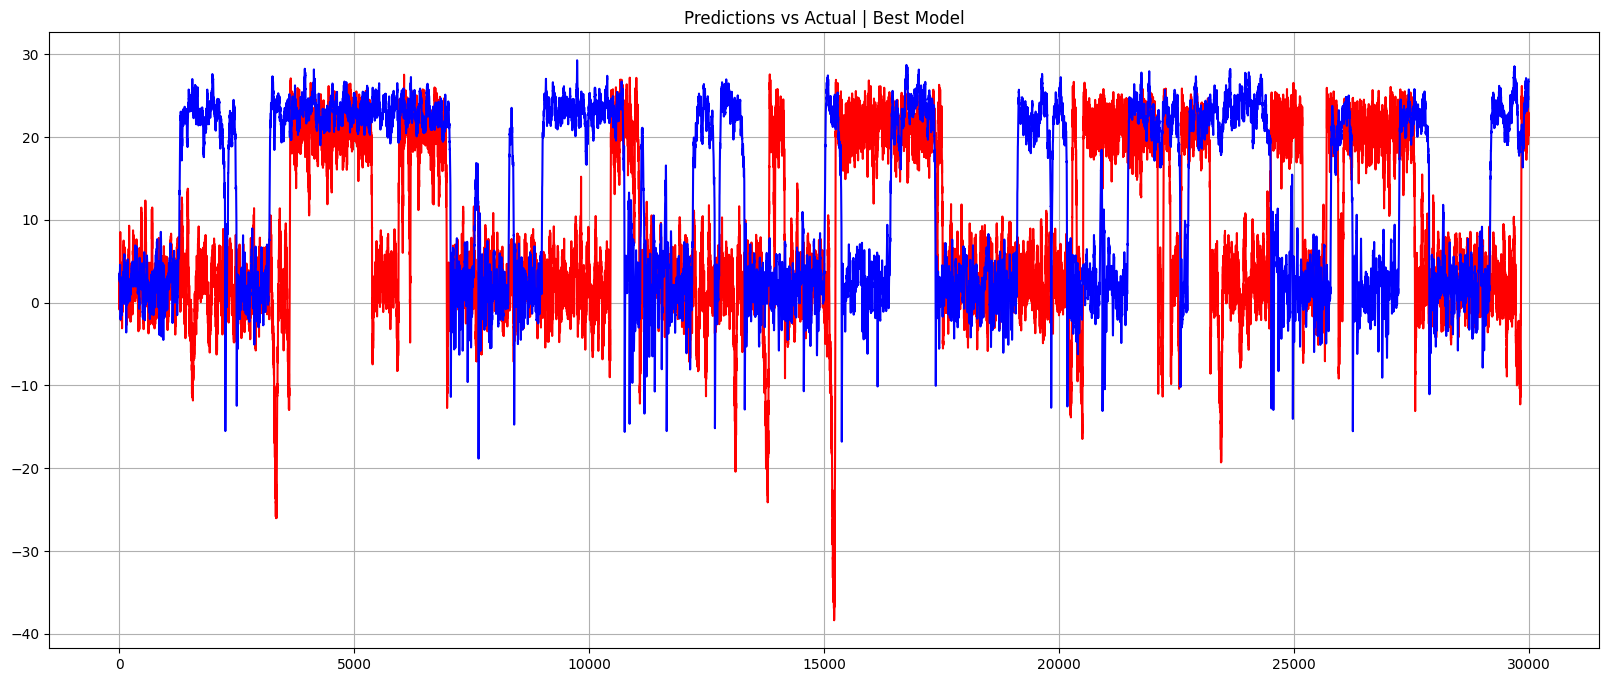

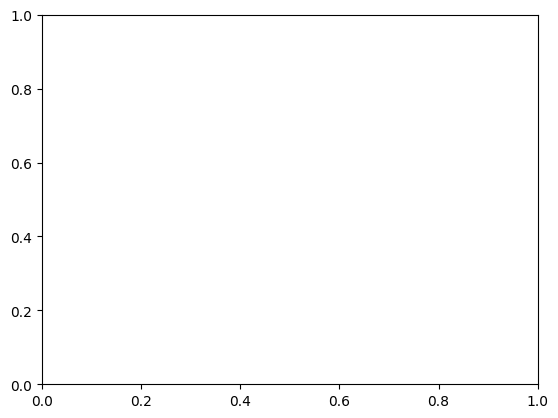

In [12]:
# Inference
import datetime
import os

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# MODIFY THIS LINE FOR MODEL TESTING
model_weights_path = r"C:\Users\danie\OneDrive\Desktop\work_torch\model_at_2025-04-07_10-30-06.155044\best_model_combined_distance.pth"

if os.path.exists(model_weights_path):
    model.load_state_dict(torch.load(model_weights_path))
    print(f"Model weights loaded from {model_weights_path}.")

initial_cond = torch.reshape(torch.tensor(psi[0,:]), [1, 75])
time_step = 30000
z = torch.zeros([1,latent_dim])
num_ens = 1
pred = np.zeros ([time_step, 75, num_ens])

for k in tqdm(range(time_step)):

    for ens in range (0, num_ens):
        if (k ==0 ):

            z = torch.randn_like(z)
            print(z.shape, initial_cond.shape)
            y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()
            pred[k,:,ens] = y
            y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
            initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

        else:
            select_ens = np.random.randint(0,num_ens,1)
            z = torch.randn_like(z)
            y = (model.decode(z.float().cuda(),torch.reshape(torch.tensor(pred[k-1,:,select_ens]),[1,75]).float().cuda())).detach().cpu().numpy()
            pred[k,:, ens] = y
            y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
            initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

# Denormalize final preds
print(std_psi[:, 63])
pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

# Denormalize test labels
actual_values = psi[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
print(actual_values)

plt.figure(figsize=(20,8))
plt.plot(pred_mean[0:30000,63],'r')
plt.plot(actual_values[0:30000],'b')
plt.grid(True)
plt.title(f"Predictions vs Actual | Best Model")
plt.savefig(rf'C:\Users\danie\OneDrive\Desktop\work_torch\prediction.vs.actual_{timestamp}.jpg')
plt.show()
plt.cla()

# MODIFY THIS LINE FOR MODEL TESTING
np.save(rf'C:\Users\danie\OneDrive\Desktop\work_torch\predictions_at_{timestamp}', pred_mean)

[10.68167255]
[2.89674618 3.06736511 3.49377703 ... 4.18280129 3.63347566 3.84053554]


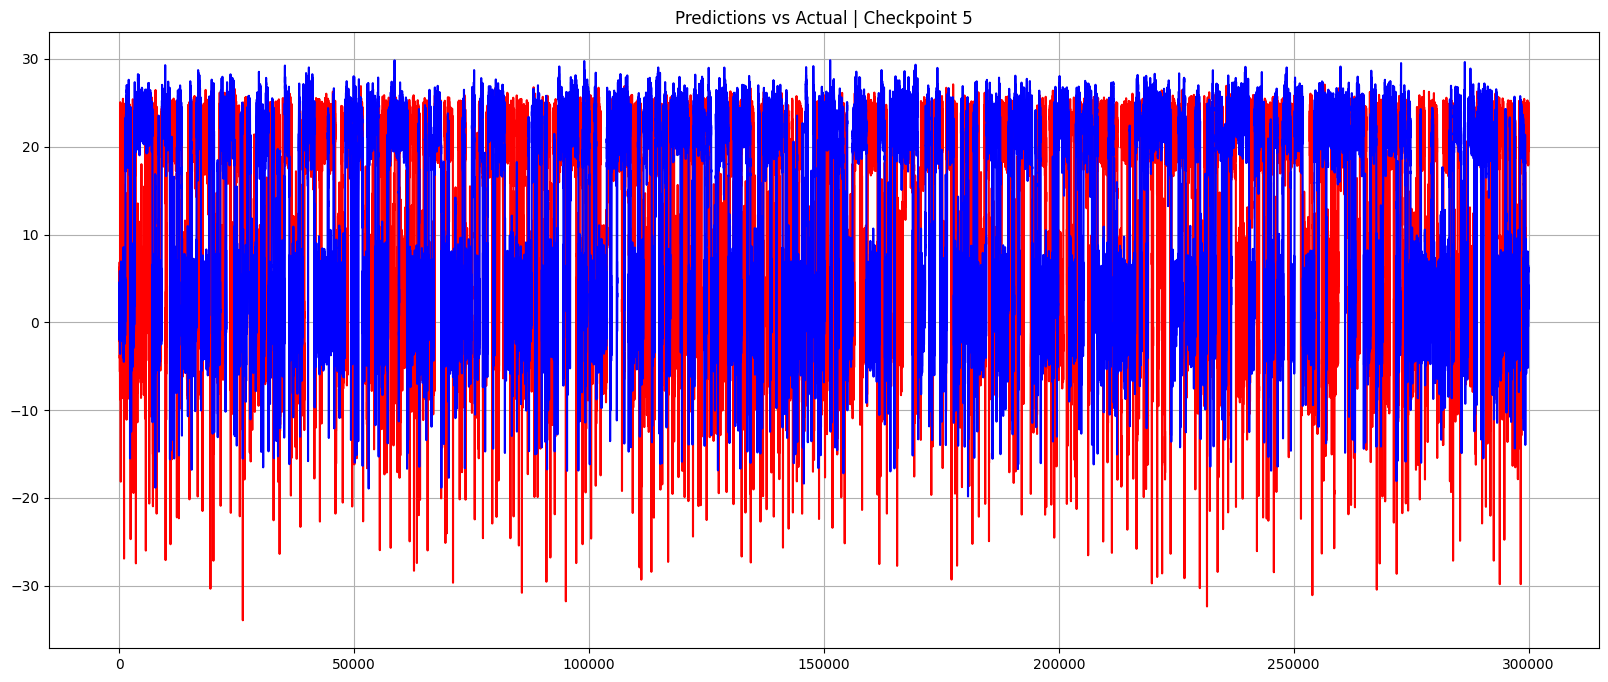

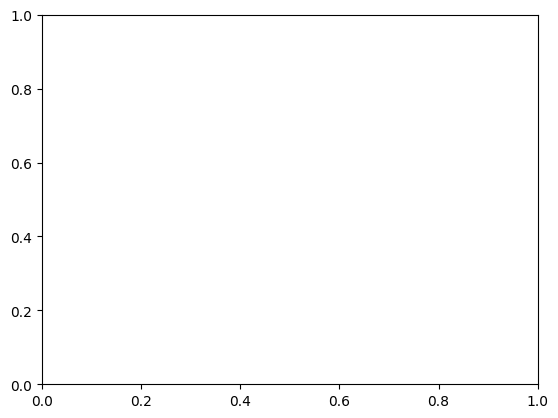

In [ ]:
# Denormalize final preds
print(std_psi[:, 63])
pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

# Denormalize test labels
actual_values = psi[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
print(actual_values)

plt.figure(figsize=(20,8))
plt.plot(pred_mean[0:300000,63],'r')
plt.plot(actual_values[0:300000],'b')
plt.grid(True)
plt.title(f"Predictions vs Actual")
plt.savefig(f'{folder}/prediction_vs_actual.png')
plt.show()
plt.cla()

# Testing the Predictive Model

## Overview
This section outlines our testing strategy to validate the accuracy, robustness, and reliability of our predictive model. Rigorous testing is critical to ensure that our model performs well under various tests.
Set flags to 1 based on which metric(s) you would like to test.

In the next cell are the flags and some basic parameters.

In [63]:
#FLAGS to determine testing
plot_data = 1
#what level do you want to plot
level = 63
CCDF = 1
Bi_modal_distribution = 1
single_step_profiles = 1
#for the single_step_profiles
NUM_SAMPLES = 5
#what weights do you want to use?
MODEL_PATH = r"C:\Users\danie\OneDrive\Desktop\work_torch\model_at_2025-04-03_13-08-07.938708\best_model_combined_distance.pth"
LEVEL = 63

There are two paths here that you will manually set. One to the physical data and the other to the predictions. 
# WARNING
Unless you're running new tests...
Do not run this cell multiple times after testing as it will create a new folder based on your current time!

In [64]:
#Initialize Data
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Load the data; shape = (300000, 2, 75)
real_data = np.load(r"C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy")
predictions = np.load(r"C:\Users\danie\OneDrive\Desktop\work_torch\predictions_at_2025-04-03_13-08-07.938708.npy")

#reshape the predictions so that it matches the real_data shape
predictions = predictions.reshape(300000, 1, 75)
print(predictions.shape)
print(real_data.shape)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"testing_at_{timestamp}"
os.mkdir(folder)
subfolders = ['timeseries', 'CCDF', 'bi_modal_distribution', 'single_step_profiles']
# Create each subdirectory inside the main folder
for subfolder in subfolders:
    path = os.path.join(folder, subfolder)
    os.mkdir(path)
    print(f"Created subfolder: {path}")
SAVE_DIR = os.path.join(folder, "single_step_profiles")

(300000, 1, 75)
(309700, 2, 75)
Created subfolder: testing_at_2025-04-04_11-21-36.481702\timeseries
Created subfolder: testing_at_2025-04-04_11-21-36.481702\CCDF
Created subfolder: testing_at_2025-04-04_11-21-36.481702\bi_modal_distribution
Created subfolder: testing_at_2025-04-04_11-21-36.481702\single_step_profiles


In [ ]:
# CCDF Error bars

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import seaborn as sns

CCDF_sum = 0

import datetime
import os

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# MODIFY THIS LINE FOR MODEL TESTING
model_weights_path = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/Resnet_VAE_model_at_2025-03-25 16:07:01.635719/checkpoint_4_promising"

if os.path.exists(model_weights_path):
    model.load_state_dict(torch.load(model_weights_path))
    print(f"Model weights loaded from {model_weights_path}.")
    
for i in range(0, 10):
    # Inference
    initial_cond = torch.reshape(torch.tensor(psi[0,:]), [1, 75])
    time_step = 300000
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros ([time_step, 75, num_ens])

    for k in range (0, time_step):

        for ens in range (0, num_ens):
            if (k ==0):

                z = torch.randn_like(z)
                print(z.shape, initial_cond.shape)
                y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()
                pred[k,:,ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

            else:
                select_ens = np.random.randint(0,num_ens,1)
                z = torch.randn_like(z)
                y = (model.decode(z.float().cuda(),torch.reshape(torch.tensor(pred[k-1,:,select_ens]),[1,75]).float().cuda())).detach().cpu().numpy()
                pred[k,:, ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

    # Denormalize final preds
    print(std_psi[:, 63])
    pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

    # Denormalize test labels
    actual_values = psi[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
    print(actual_values)

    # Load the data; shape = (300000, 2, 75)
    real_data = np.load(r"/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
    predictions = pred_mean.reshape(300000, 1, 75)

    if (CCDF):
        real_data_1d = real_data[:, 1, 63]  # Now shape is (309700,)
        predictions_1d = predictions[:, 0, 63]  # shape (300000,)

        # Define bounds (assuming they apply to both datasets)
        upper_bound = 53.8 / 2.8935
        lower_bound = 1.75 / 2.8935

        # Function to calculate transition durations
        def calculate_transition_durations(y_values, upper_bound, lower_bound):
            times_between_transitions = []
            transition_start = None
            above_upper = False
            below_lower = False

            for i in range(1, len(y_values)):
                if y_values[i] < lower_bound:  
                    below_lower = True
                    above_upper = False
                elif y_values[i] > upper_bound:  
                    if below_lower and transition_start is not None:
                        times_between_transitions.append(i - transition_start)
                        transition_start = None  
                    above_upper = True
                    below_lower = False

                if below_lower and transition_start is None:
                    transition_start = i

            return times_between_transitions

        # Compute transition durations for real data
        real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)

        # Compute transition durations for predictions data
        pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)

        # Plot setup
        plt.figure(figsize=(10, 6))

        def bootstrap_ci(data, num_bootstraps=1000, confidence_level=0.95):
            sample_size = len(data)
            bootstrap_means = np.zeros(num_bootstraps)
            
            for i in range(num_bootstraps):
                bootstrap_sample = np.random.choice(data, size=sample_size, replace=True)
                bootstrap_means[i] = np.mean(bootstrap_sample)
            
            ci_lower = np.percentile(bootstrap_means, (1 - confidence_level) / 2 * 100)
            ci_upper = np.percentile(bootstrap_means, (1 + confidence_level) / 2 * 100)
            
            return np.mean(data), ci_lower, ci_upper

        # === REAL DATA CCDF AND FIT ===
        if len(real_durations) == 0:
            print("No transitions detected in real data with current bounds!")
        else:
            real_data_sorted = np.sort(real_durations)
            ccdf_real = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)

            valid_indices_real = ccdf_real > 0
            x_fit_real = real_data_sorted[valid_indices_real]
            y_fit_real = np.log(ccdf_real[valid_indices_real])

            slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)

            x_line_real = np.linspace(min(x_fit_real), max(x_fit_real), 40)
            y_line_real = np.exp(slope_real * x_line_real + intercept_real)

            # Create a grid of x values (time steps / durations)

            bootstrap_mean = []
            ci_lower_vals = []
            ci_upper_vals = []

            for x in x_line_real:
                valid_indices = (real_durations > x).astype(float)
                mean_val, lower, upper = bootstrap_ci(valid_indices)
                bootstrap_mean.append(mean_val)
                ci_lower_vals.append(lower)
                ci_upper_vals.append(upper)

            bootstrap_mean = np.array(bootstrap_mean)
            ci_lower_vals = np.array(ci_lower_vals)
            ci_upper_vals = np.array(ci_upper_vals)

            # Calculate error bars (difference from the bootstrap mean)
            error_lower = bootstrap_mean - ci_lower_vals
            error_upper = ci_upper_vals - bootstrap_mean

            plt.step(real_data_sorted, ccdf_real, where='post', label='Real Data CCDF', linewidth=2, linestyle='--')
            plt.errorbar(x_line_real, bootstrap_mean, yerr=[error_lower, error_upper],
                    fmt='o', color='blue', capsize=3, ecolor='blue', label='Real Bootstrap 95% CI')
            plt.plot(x_line_real, y_line_real, 'b-', label=f'Real Exp Fit (slope={slope_real:.4f})', linewidth=2)

        # === PREDICTIONS CCDF AND FIT ===
        if len(pred_durations) == 0:
            print("No transitions detected in predictions with current bounds!")
        else:
            pred_data_sorted = np.sort(pred_durations)
            ccdf_pred = 1 - np.arange(1, len(pred_data_sorted) + 1) / len(pred_data_sorted)

            valid_indices_pred = ccdf_pred > 0
            x_fit_pred = pred_data_sorted[valid_indices_pred]
            y_fit_pred = np.log(ccdf_pred[valid_indices_pred])

            slope_pred, intercept_pred, *_ = linregress(x_fit_pred, y_fit_pred)

            x_line_pred = np.linspace(min(x_fit_pred), max(x_fit_pred), 40)
            y_line_pred = np.exp(slope_pred * x_line_pred + intercept_pred)

            # Create a grid of x values (time steps / durations)

            bootstrap_mean = []
            ci_lower_vals = []
            ci_upper_vals = []

            for x in x_line_pred:
                valid_indices = (pred_durations > x).astype(float)
                mean_val, lower, upper = bootstrap_ci(valid_indices)
                bootstrap_mean.append(mean_val)
                ci_lower_vals.append(lower)
                ci_upper_vals.append(upper)

            bootstrap_mean = np.array(bootstrap_mean)
            ci_lower_vals = np.array(ci_lower_vals)
            ci_upper_vals = np.array(ci_upper_vals)

            # Calculate error bars (difference from the bootstrap mean)
            error_lower = bootstrap_mean - ci_lower_vals
            error_upper = ci_upper_vals - bootstrap_mean

            plt.step(pred_data_sorted, ccdf_pred, where='post', label='Predictions CCDF', linewidth=2, linestyle='-.', color='red')
            plt.errorbar(x_line_pred, bootstrap_mean, yerr=[error_lower, error_upper],
                    fmt='o', color='red', capsize=3, ecolor='red', label='Pred Bootstrap 95% CI')
            plt.plot(x_line_pred, y_line_pred, 'r-', label=f'Pred Exp Fit (slope={slope_pred:.4f})', linewidth=2)

            CCDF_sum += slope_pred

        # Plot labels and formatting
        plt.xlabel('Time Duration (Steps)')
        plt.ylabel('CCDF')
        plt.title('CCDF of Time Between B->A and A->B Transitions (Exponential Fit)')
        plt.yscale("log")  # y-axis log scale
        plt.xscale("linear")  # x-axis linear scale
        plt.grid()
        plt.legend()
        plt.tight_layout()
        save_path = os.path.join(folder, "CCDF")
        save_path = os.path.join(save_path, f"CCDF_plot{i}")
        plt.savefig(save_path)
        plt.show()

CCDF_avg = CCDF_sum/10
print(CCDF_avg)

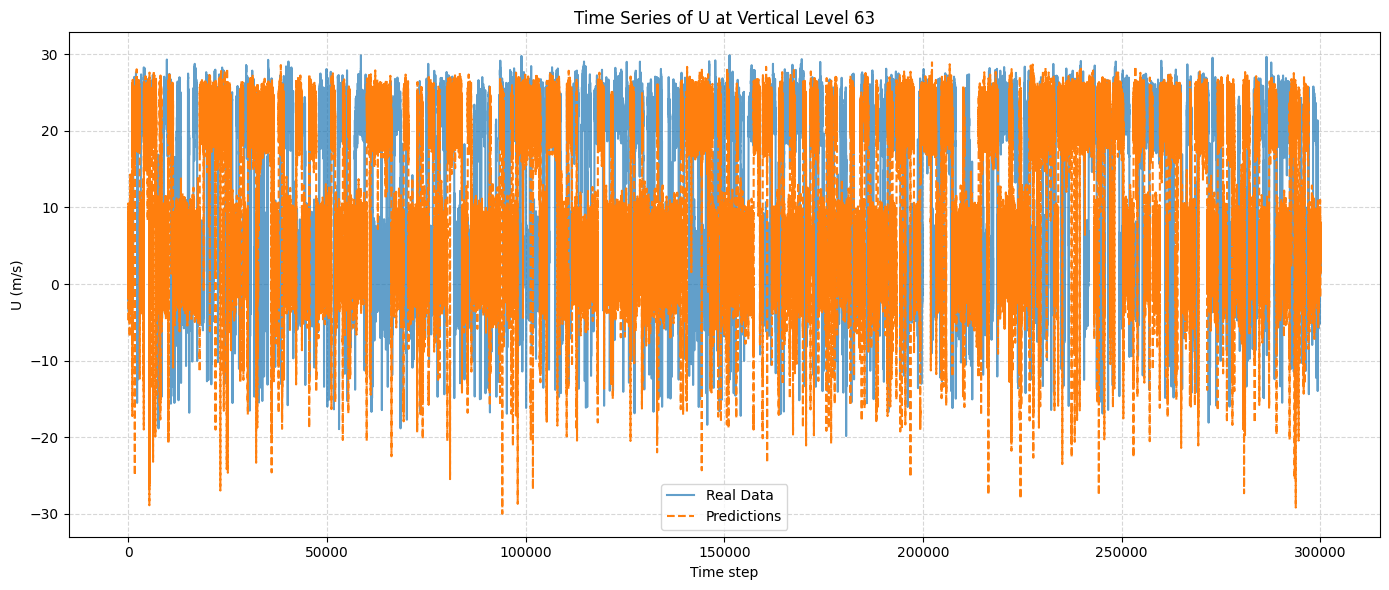

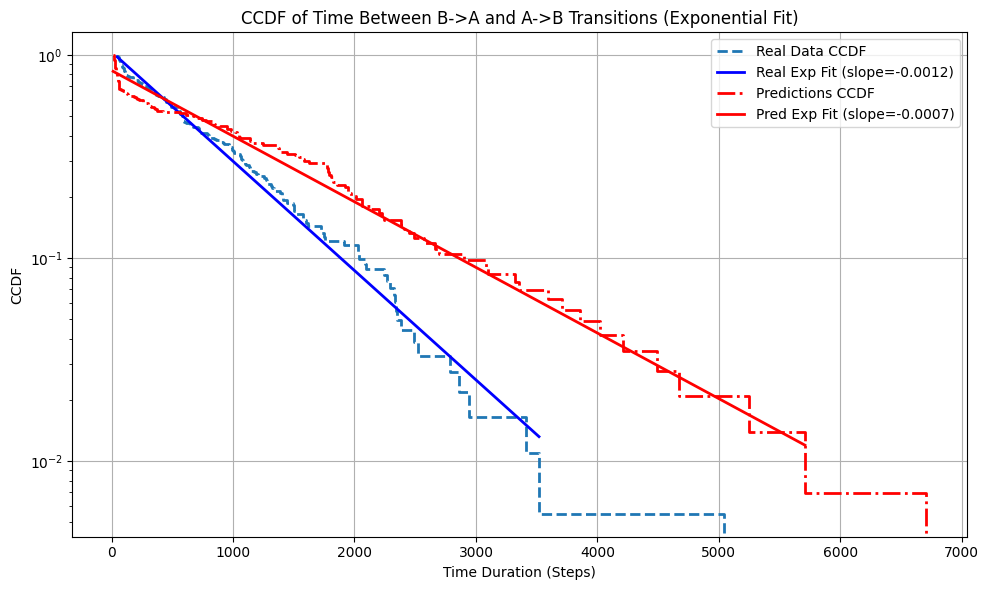

Shape of zonal_wind_data_real: (309700,)
Shape of zonal_wind_data_predictions: (300000,)


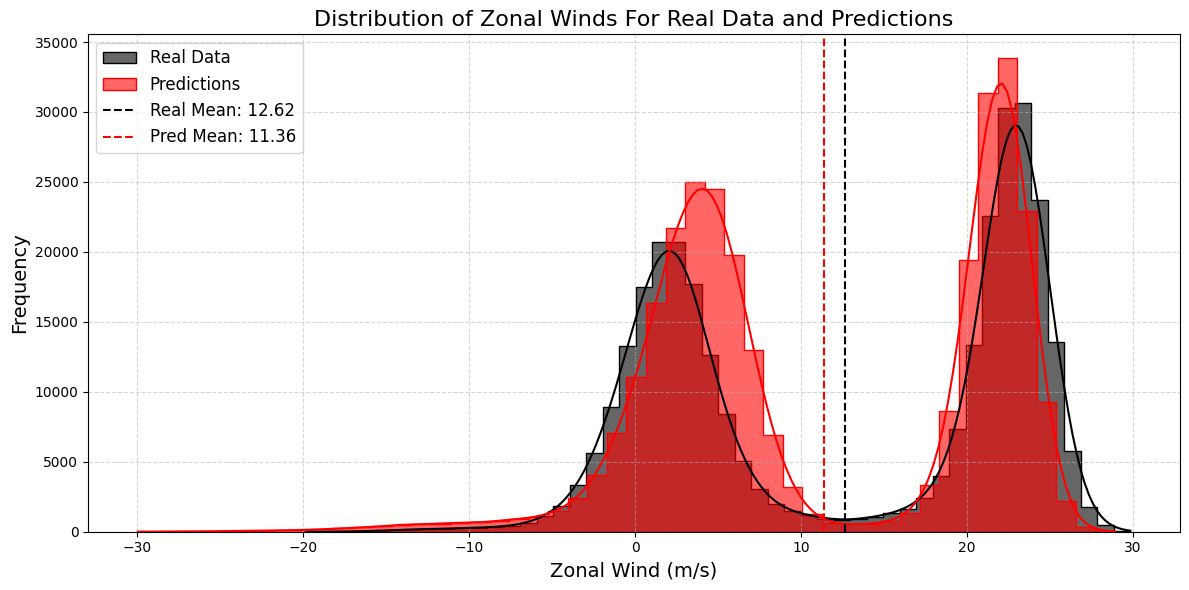

C:\Users\danie\AppData\Local\Temp\ipykernel_44664\1451780765.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Randomly sampled time steps: [79633, 268242, 143520, 113471, 252466]


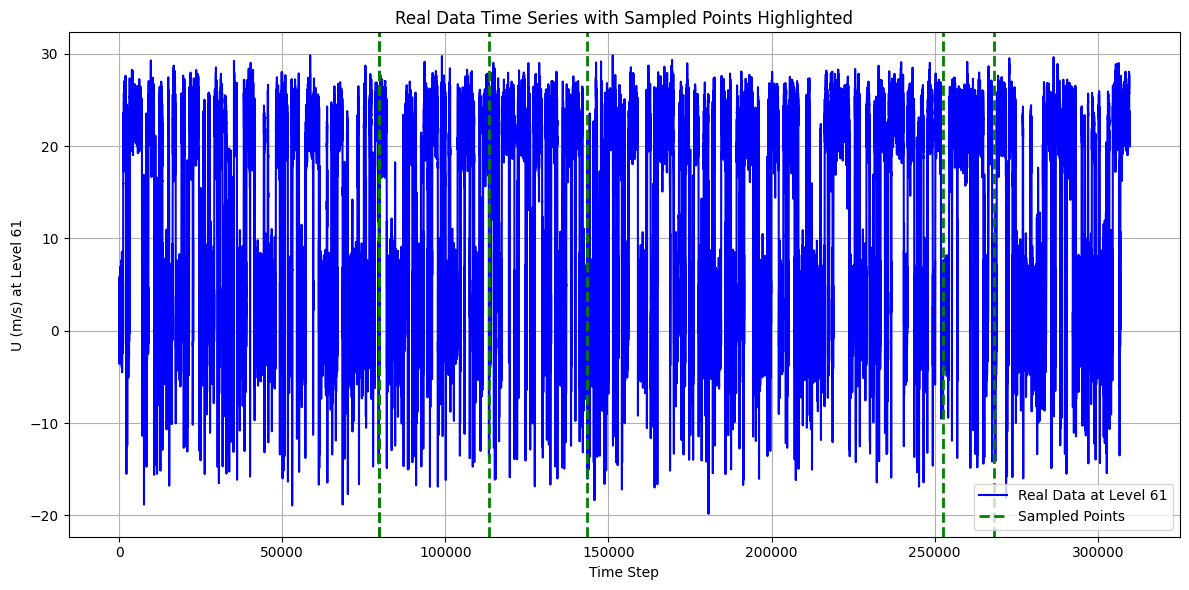

Using device: cuda
torch.Size([1, 1024]) torch.Size([1, 75])


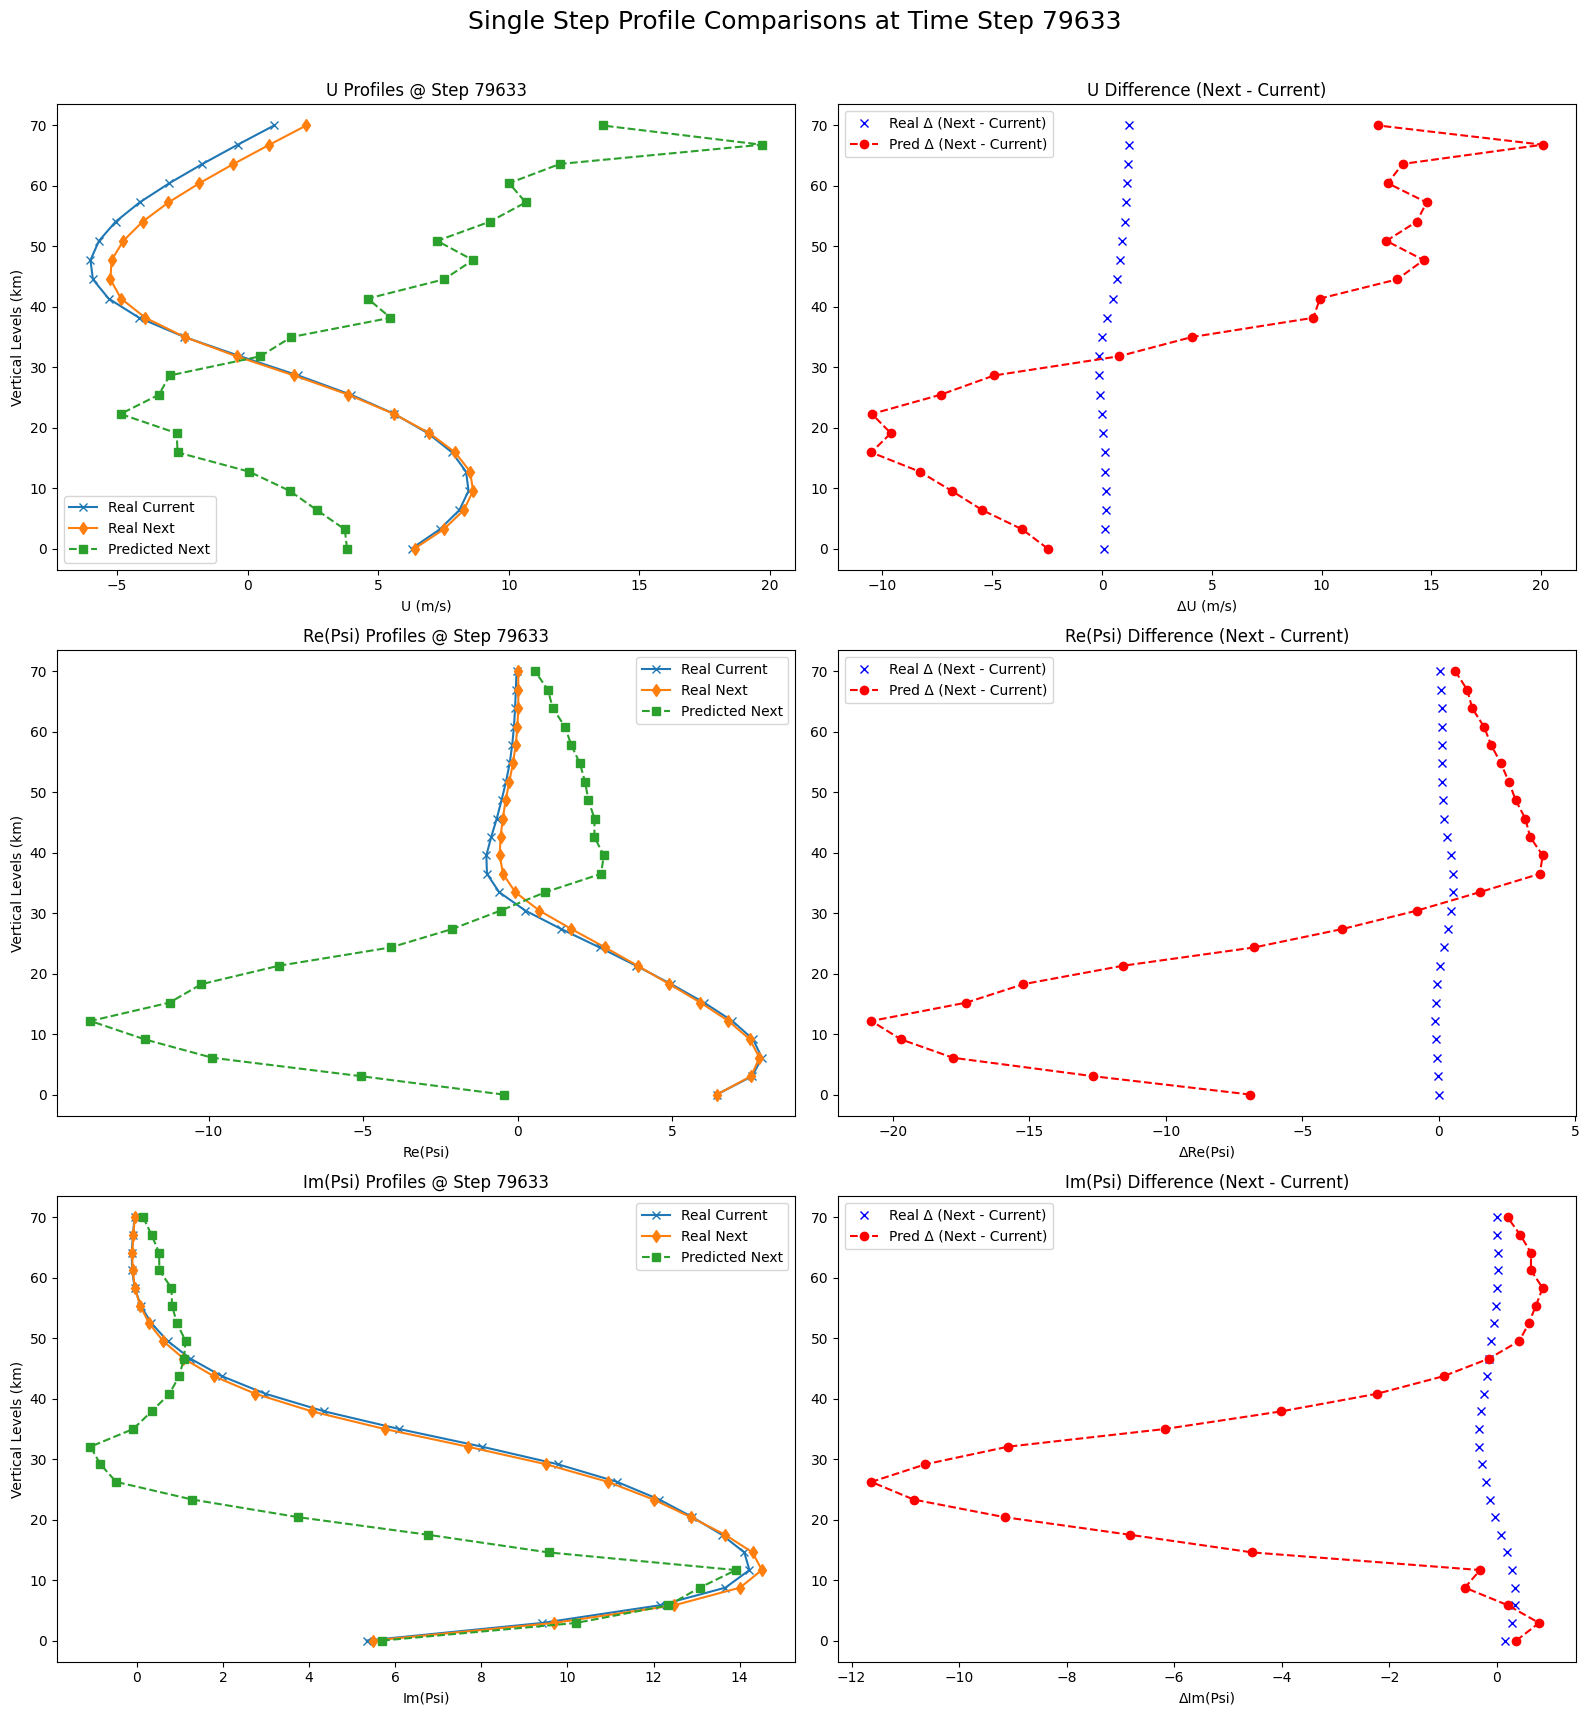

Combined plot saved for sampled point 79633
torch.Size([1, 1024]) torch.Size([1, 75])


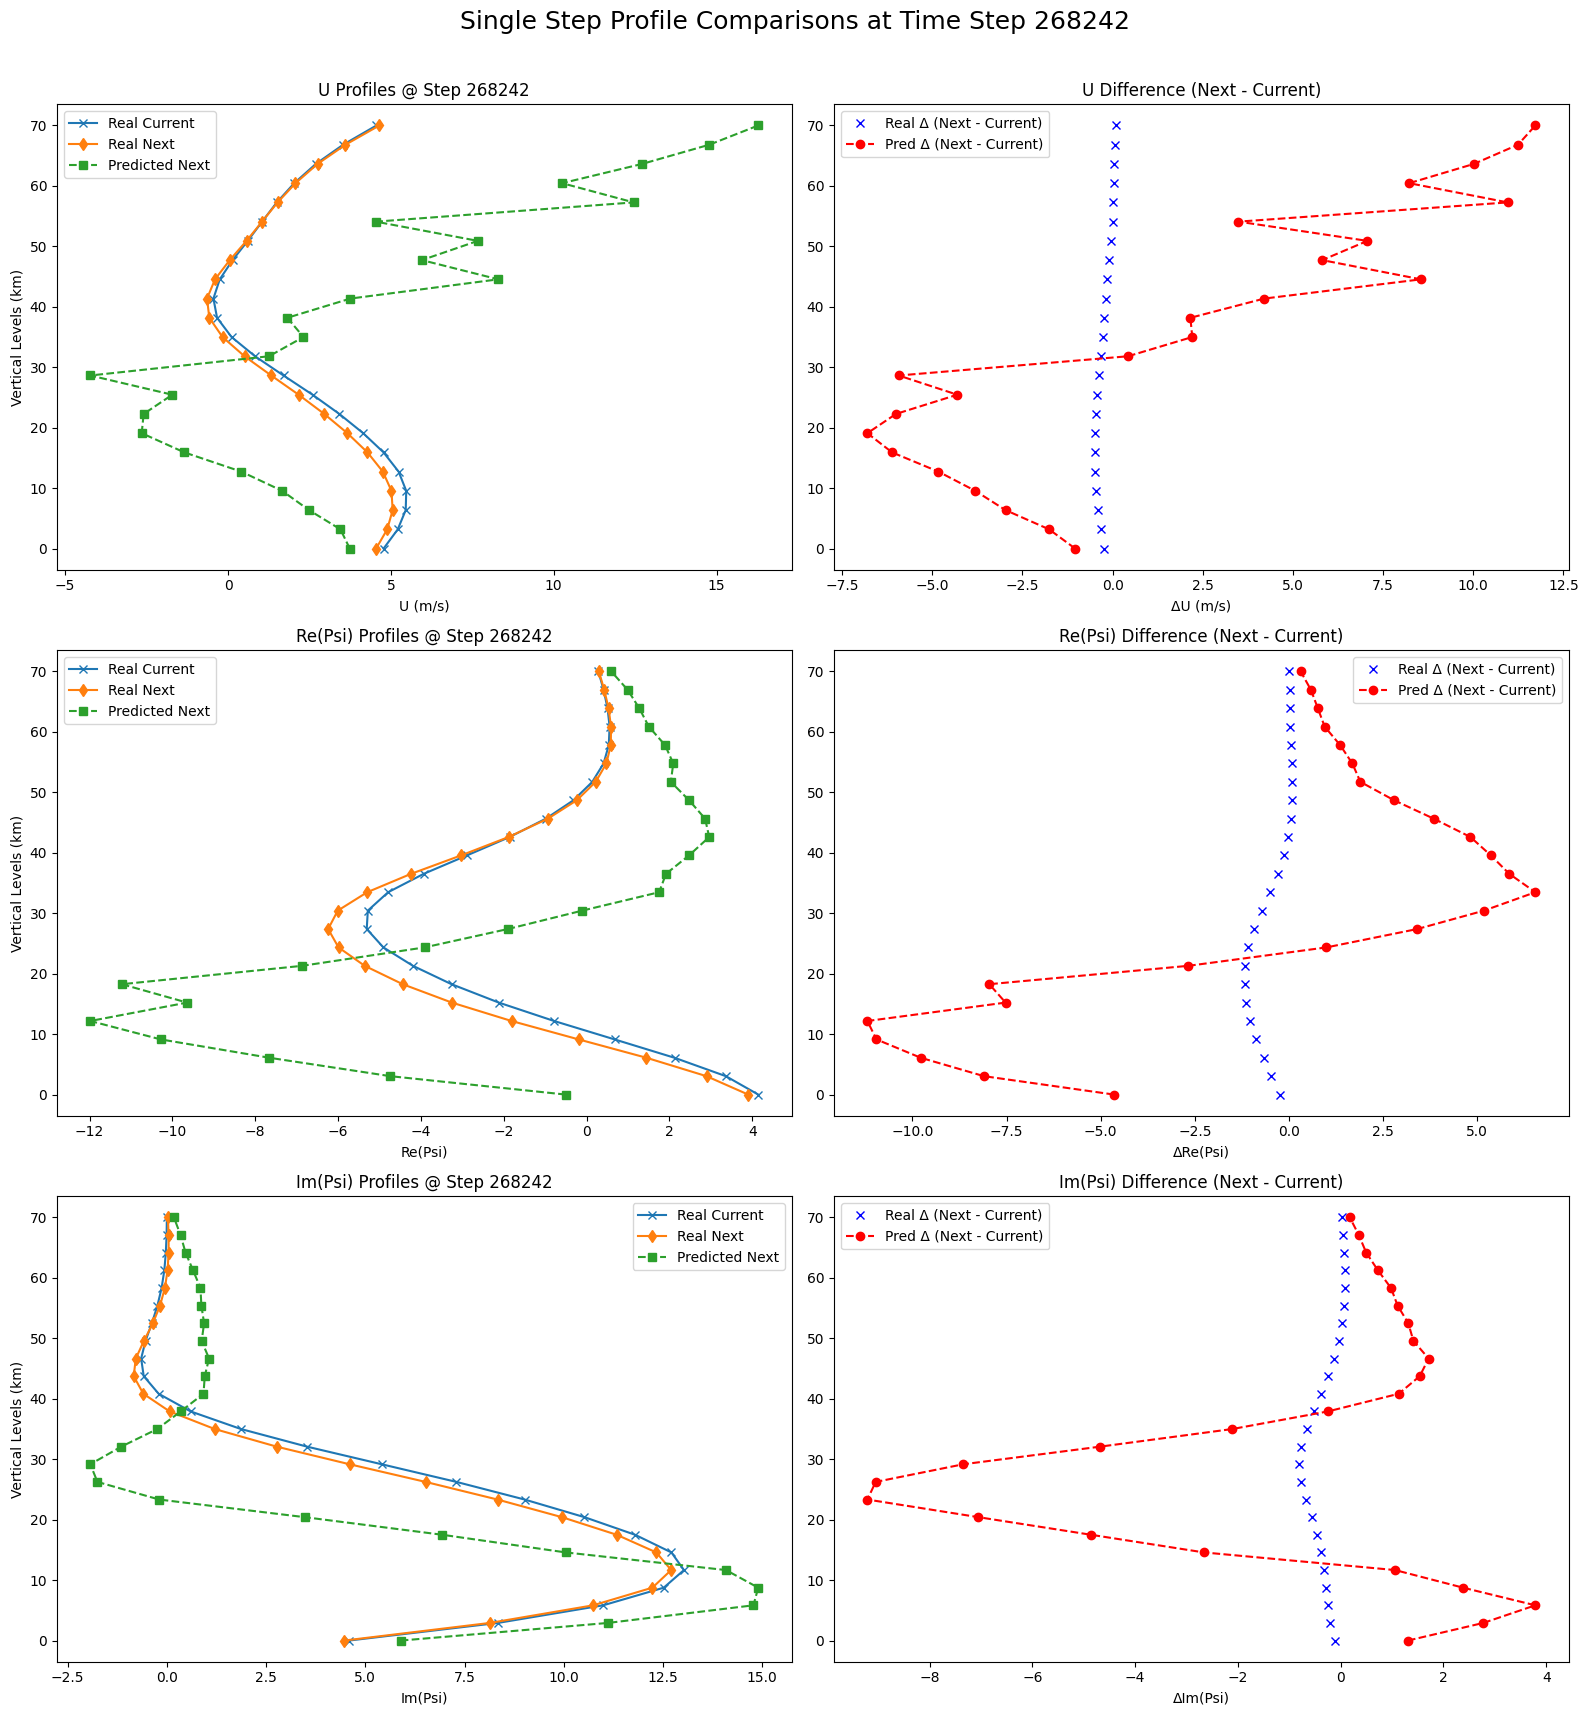

Combined plot saved for sampled point 268242
torch.Size([1, 1024]) torch.Size([1, 75])


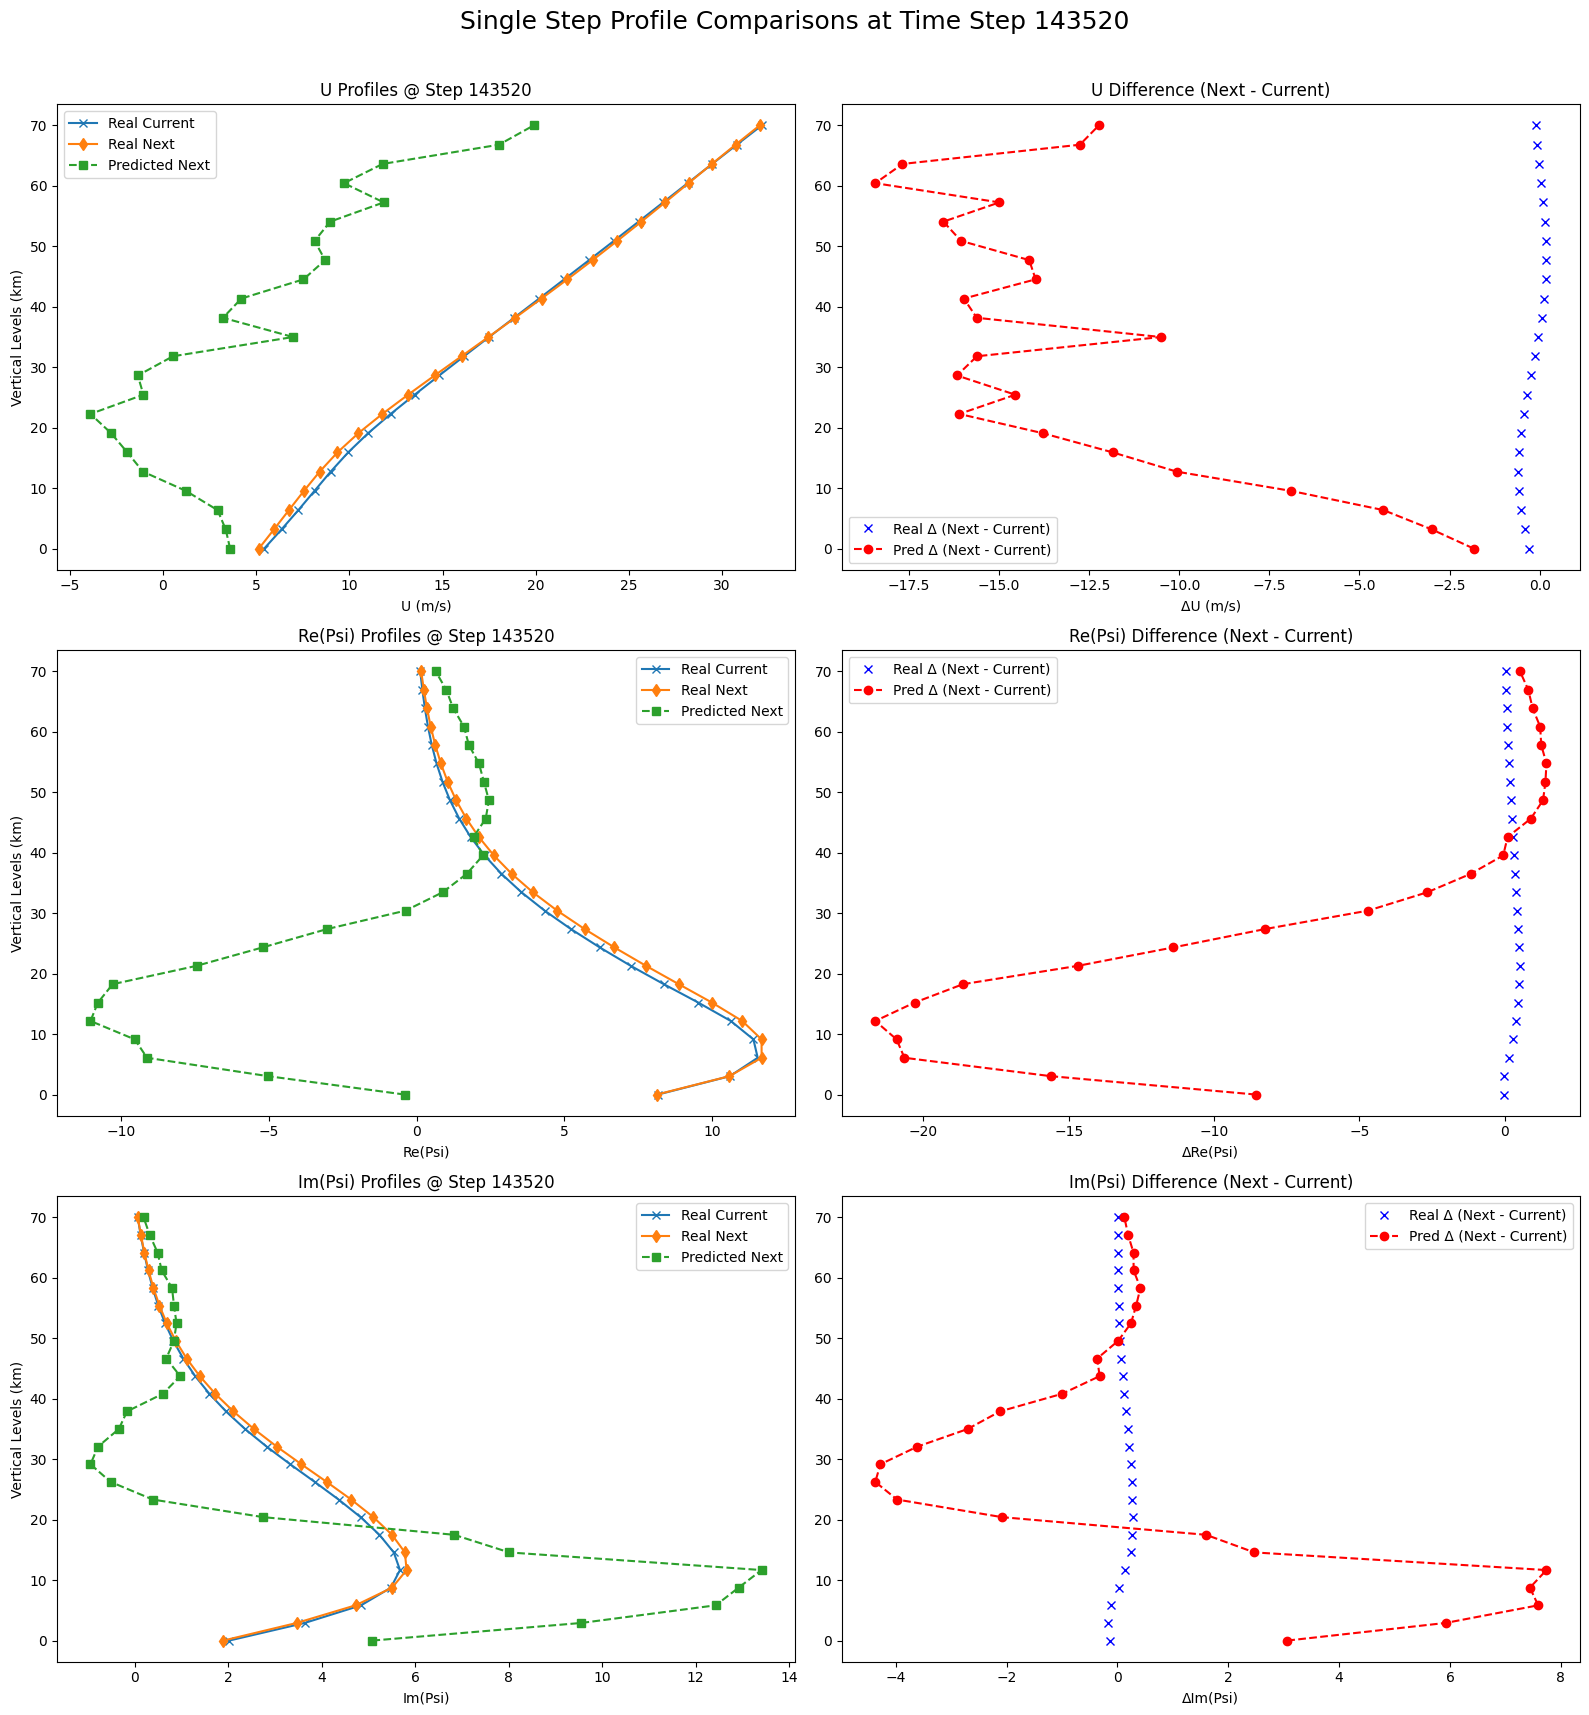

Combined plot saved for sampled point 143520
torch.Size([1, 1024]) torch.Size([1, 75])


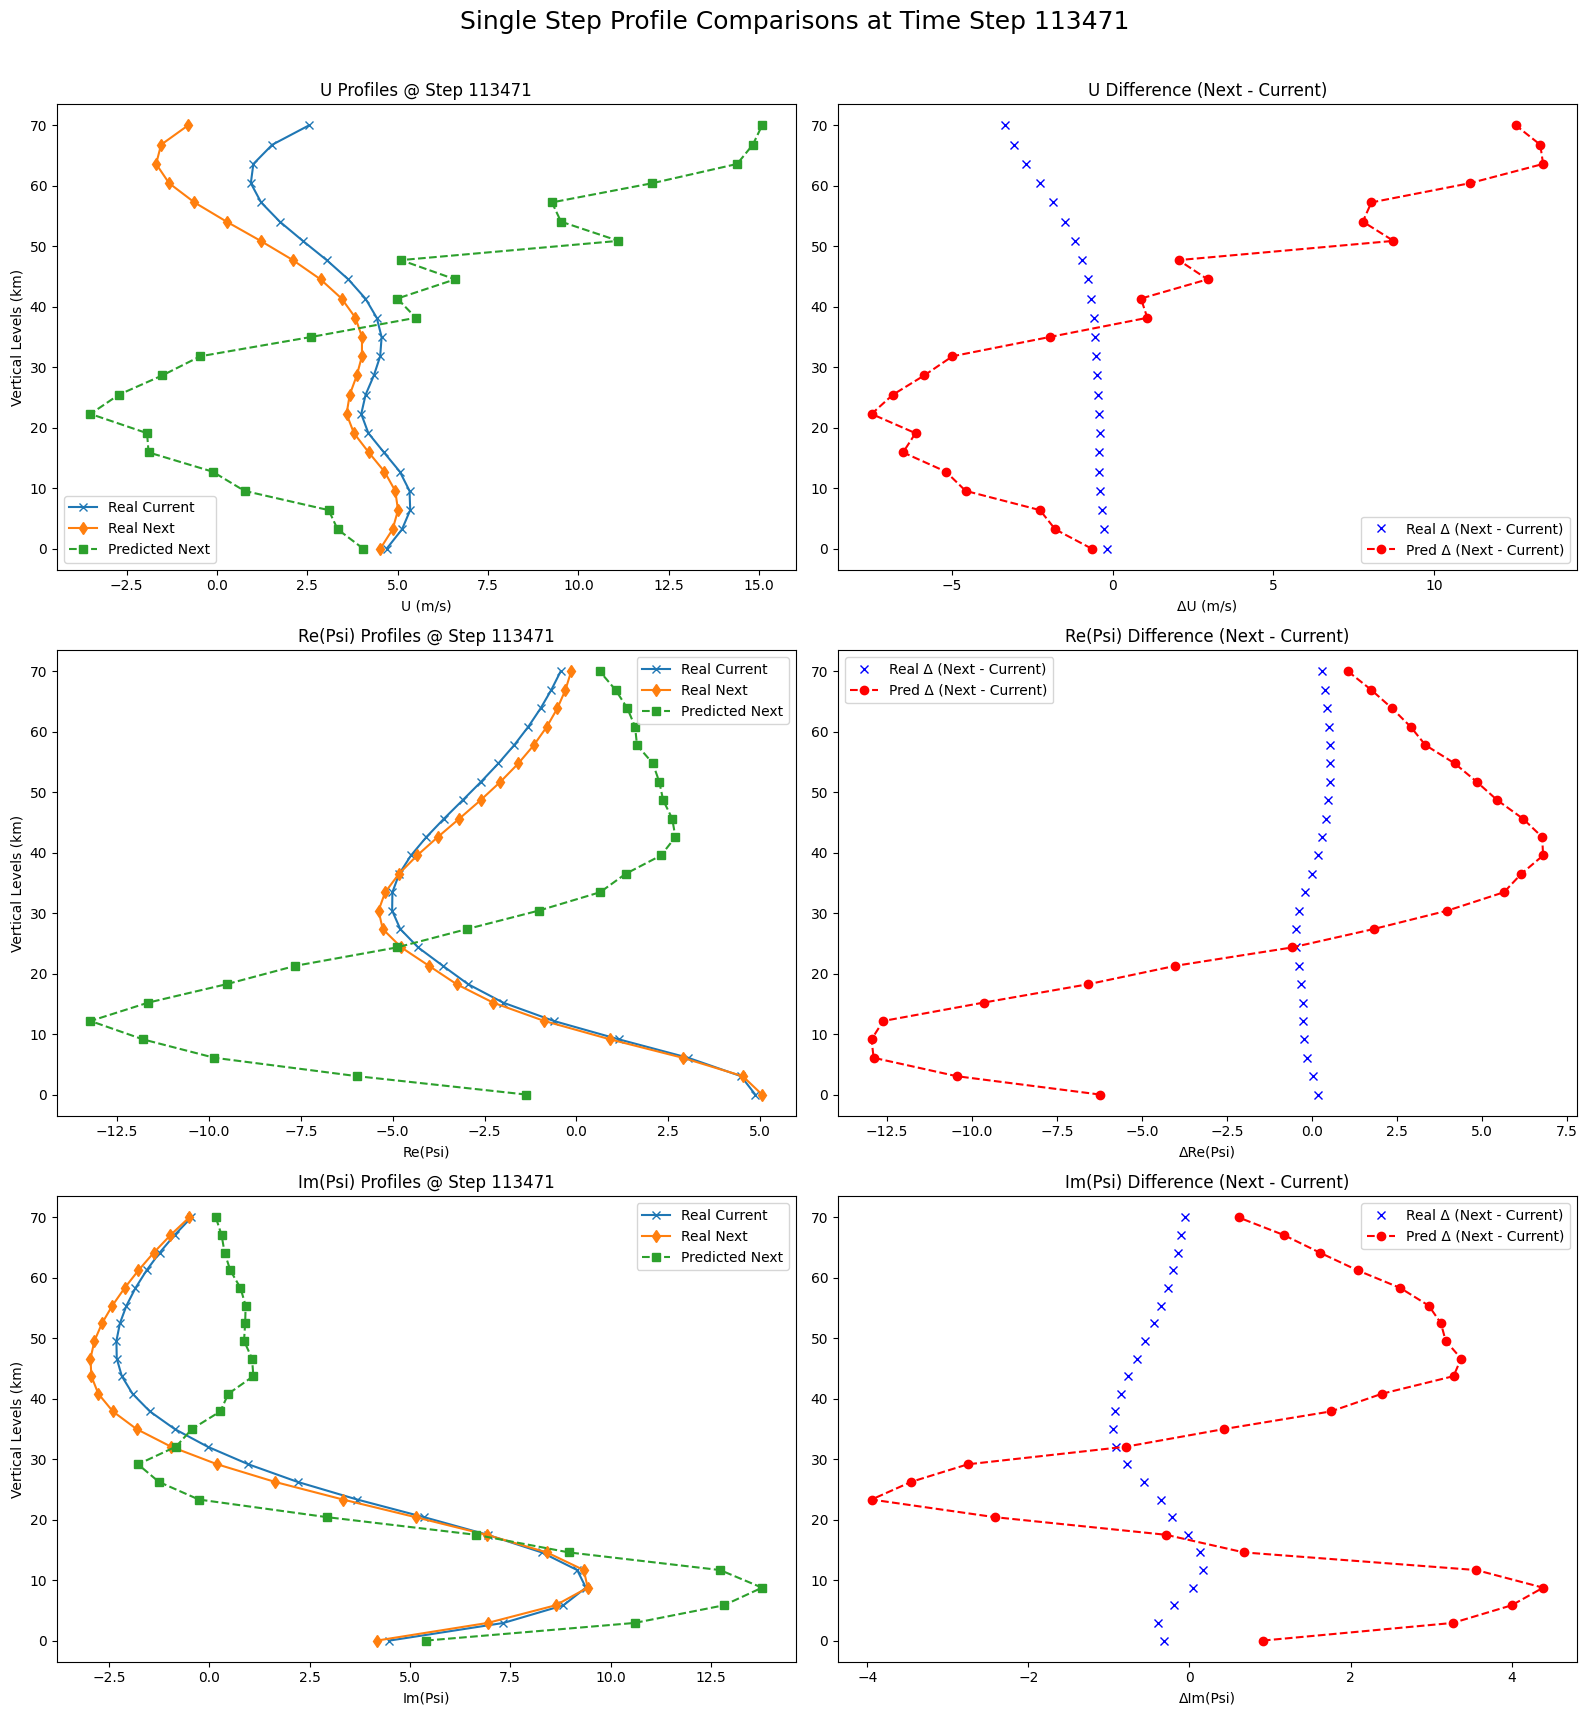

Combined plot saved for sampled point 113471
torch.Size([1, 1024]) torch.Size([1, 75])


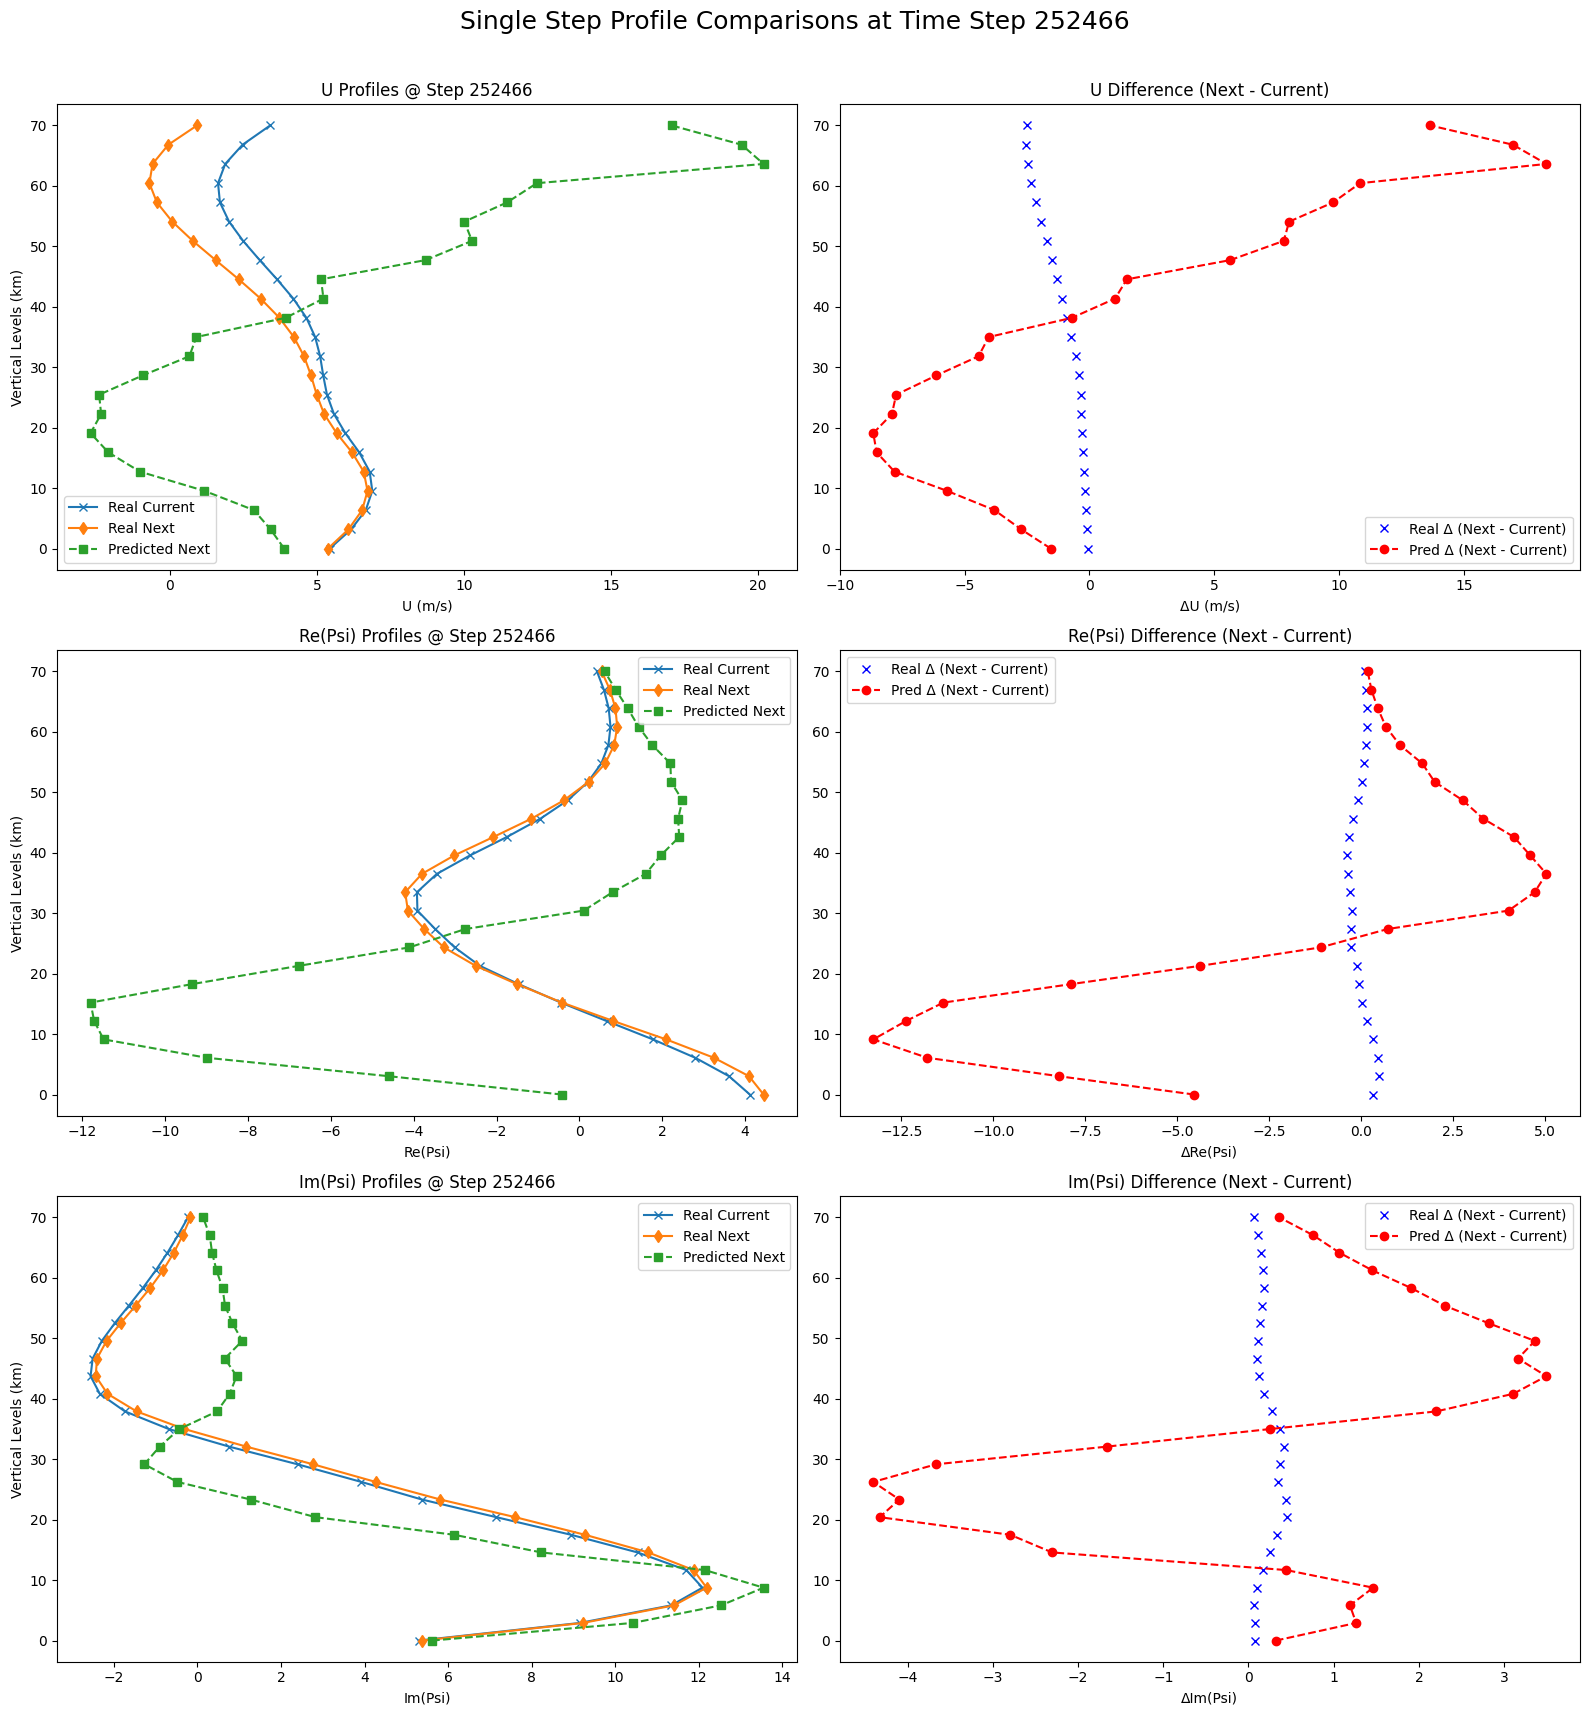

Combined plot saved for sampled point 252466
Finished processing all sampled points.
(300000, 1, 75)
(309700, 2, 75)


In [65]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
if (plot_data):
    #note that the value 300000 will have to change depending on the real and predictions data length
    u_profile_real = real_data[:300000, 1, level]  # Match time length with predictions
    u_profile_pred = predictions[:, 0, level]
    time_steps = np.arange(len(u_profile_pred))

    # === Plot ===
    plt.figure(figsize=(14, 6))

    plt.plot(time_steps, u_profile_real, label='Real Data', alpha=0.7)
    plt.plot(time_steps, u_profile_pred, label='Predictions', linestyle='--')


    # Labels, legend, and formatting
    plt.xlabel('Time step')
    plt.ylabel('U (m/s)')
    plt.title(f'Time Series of U at Vertical Level {level}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "timeseries")
    save_path = os.path.join(save_path, "real_prediction_plot")
    plt.savefig(save_path)
    plt.show()

if (CCDF):
    real_data_1d = real_data[:, 1, 61]  # Now shape is (309700,)
    predictions_1d = predictions[:, 0, 61]  # shape (300000,)

    # Define bounds (assuming they apply to both datasets)
    upper_bound = 53.8 / 2.8935
    lower_bound = 1.75 / 2.8935

    # Function to calculate transition durations
    def calculate_transition_durations(y_values, upper_bound, lower_bound):
        times_between_transitions = []
        transition_start = None
        above_upper = False
        below_lower = False

        for i in range(1, len(y_values)):
            if y_values[i] < lower_bound:  
                below_lower = True
                above_upper = False
            elif y_values[i] > upper_bound:  
                if below_lower and transition_start is not None:
                    times_between_transitions.append(i - transition_start)
                    transition_start = None  
                above_upper = True
                below_lower = False

            if below_lower and transition_start is None:
                transition_start = i

        return times_between_transitions

    # Compute transition durations for real data
    real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)

    # Compute transition durations for predictions data
    pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)

    # Plot setup
    plt.figure(figsize=(10, 6))

    # === REAL DATA CCDF AND FIT ===
    if len(real_durations) == 0:
        print("No transitions detected in real data with current bounds!")
    else:
        real_data_sorted = np.sort(real_durations)
        ccdf_real = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)

        valid_indices_real = ccdf_real > 0
        x_fit_real = real_data_sorted[valid_indices_real]
        y_fit_real = np.log(ccdf_real[valid_indices_real])

        slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)

        x_line_real = np.linspace(min(x_fit_real), max(x_fit_real), 100)
        y_line_real = np.exp(slope_real * x_line_real + intercept_real)

        plt.step(real_data_sorted, ccdf_real, where='post', label='Real Data CCDF', linewidth=2, linestyle='--')
        plt.plot(x_line_real, y_line_real, 'b-', label=f'Real Exp Fit (slope={slope_real:.4f})', linewidth=2)

    # === PREDICTIONS CCDF AND FIT ===
    if len(pred_durations) == 0:
        print("No transitions detected in predictions with current bounds!")
    else:
        pred_data_sorted = np.sort(pred_durations)
        ccdf_pred = 1 - np.arange(1, len(pred_data_sorted) + 1) / len(pred_data_sorted)

        valid_indices_pred = ccdf_pred > 0
        x_fit_pred = pred_data_sorted[valid_indices_pred]
        y_fit_pred = np.log(ccdf_pred[valid_indices_pred])

        slope_pred, intercept_pred, *_ = linregress(x_fit_pred, y_fit_pred)

        x_line_pred = np.linspace(min(x_fit_pred), max(x_fit_pred), 100)
        y_line_pred = np.exp(slope_pred * x_line_pred + intercept_pred)

        plt.step(pred_data_sorted, ccdf_pred, where='post', label='Predictions CCDF', linewidth=2, linestyle='-.', color='red')
        plt.plot(x_line_pred, y_line_pred, 'r-', label=f'Pred Exp Fit (slope={slope_pred:.4f})', linewidth=2)

    # Plot labels and formatting
    plt.xlabel('Time Duration (Steps)')
    plt.ylabel('CCDF')
    plt.title('CCDF of Time Between B->A and A->B Transitions (Exponential Fit)')
    plt.yscale("log")  # y-axis log scale
    plt.xscale("linear")  # x-axis linear scale
    plt.grid()
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(folder, "CCDF")
    save_path = os.path.join(save_path, "CCDF_plot")
    plt.savefig(save_path)
    plt.show()
if (Bi_modal_distribution):
    zonal_wind_data_real = real_data[:, 1, 63]  # variable index 1 (e.g., zonal wind), level 60
    zonal_wind_data_predictions = predictions[:, 0, 63]  # variable index 0 (predictions), level 60

    print(f"Shape of zonal_wind_data_real: {zonal_wind_data_real.shape}")
    print(f"Shape of zonal_wind_data_predictions: {zonal_wind_data_predictions.shape}")

    # Plot the bimodal histogram
    plt.figure(figsize=(12, 6))

    # Create histograms (overlaid)
    sns.histplot(zonal_wind_data_real, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data')
    sns.histplot(zonal_wind_data_predictions, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions')

    # Customize plot labels and title
    plt.title('Distribution of Zonal Winds For Real Data and Predictions', fontsize=16)
    plt.xlabel('Zonal Wind (m/s)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add vertical lines at means
    plt.axvline(np.mean(zonal_wind_data_real), color='black', linestyle='--', label=f'Real Mean: {np.mean(zonal_wind_data_real):.2f}')
    plt.axvline(np.mean(zonal_wind_data_predictions), color='red', linestyle='--', label=f'Pred Mean: {np.mean(zonal_wind_data_predictions):.2f}')

    # Final plot settings
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "bi_modal_distribution")
    save_path = os.path.join(save_path, "bi_modal_distribution_plot")
    plt.savefig(save_path)
    plt.show()
if (single_step_profiles):
    # Ensure save directory exists
    os.makedirs(SAVE_DIR, exist_ok=True)

    # === Load model weights ===
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

    # === Randomly sample time points from real data ===
    time_indices = random.sample(range(0, real_data.shape[0] - 2), NUM_SAMPLES)
    print(f"Randomly sampled time steps: {time_indices}")

    # === Time series visualization ===
    real_data_timeseries = real_data[:, 1, LEVEL]
    time_steps_all = np.arange(len(real_data_timeseries))

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps_all, real_data_timeseries, label="Real Data at Level 61", color='blue')

    # Mark sample points
    for idx_num, idx in enumerate(time_indices):
        plt.axvline(x=idx, color='green', linestyle='--', linewidth=2)
    if len(time_indices) > 0:
        plt.axvline(x=time_indices[0], color='green', linestyle='--', linewidth=2, label='Sampled Points')

    plt.title("Real Data Time Series with Sampled Points Highlighted")
    plt.xlabel("Time Step")
    plt.ylabel("U (m/s) at Level 61")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = os.path.join(SAVE_DIR, "real_data_timeseries_with_samples.png")
    plt.savefig(save_path)
    plt.show()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # === Iterate over each sampled time point ===
    for i, time_step in enumerate(time_indices):
        next_time_step = time_step + 1

        # === Real data: current and next ===
        real_current = real_data[time_step, 1, :]       
        real_next = real_data[next_time_step, 1, :]      

        # === Normalize real_current and make prediction for next step ===
        initial_condition_normalized = (real_current.reshape(1, 75, 1) - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1)
        current_input = torch.tensor(initial_condition_normalized, dtype=torch.float32).to(device)

        with torch.no_grad():
            z = torch.randn_like(z)
            print(z.shape, initial_cond.shape)
            y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()

        # === Denormalize predicted next ===
        pred_next_denorm = y.squeeze() * std_psi.squeeze() + mean_psi.squeeze()

        # === Extract U, Re(Psi), Im(Psi) components ===
        # U profiles
        U_current_real = real_current[51:74]
        U_next_real = real_next[51:74]
        U_next_pred = pred_next_denorm[51:74]

        # Re(Psi) profiles
        RePsi_current_real = real_current[0:24]
        RePsi_next_real = real_next[0:24]
        RePsi_next_pred = pred_next_denorm[0:24]

        # Im(Psi) profiles
        ImPsi_current_real = real_current[25:50]
        ImPsi_next_real = real_next[25:50]
        ImPsi_next_pred = pred_next_denorm[25:50]

        # === Differences ===
        U_diff_real = U_next_real - U_current_real
        U_diff_pred = U_next_pred - U_current_real

        RePsi_diff_real = RePsi_next_real - RePsi_current_real
        RePsi_diff_pred = RePsi_next_pred - RePsi_current_real

        ImPsi_diff_real = ImPsi_next_real - ImPsi_current_real
        ImPsi_diff_pred = ImPsi_next_pred - ImPsi_current_real

        # === Create a single figure with 3 rows (U, Re(Psi), Im(Psi)) ===
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # 3 rows, 2 columns (Profile and Difference)

        z_levels_U = np.linspace(0, 70, 23)
        z_levels_RePsi = np.linspace(0, 70, 24)
        z_levels_ImPsi = np.linspace(0, 70, 25)

        # --- U ---
        axes[0, 0].plot(U_current_real, z_levels_U, 'x-', label="Real Current")
        axes[0, 0].plot(U_next_real, z_levels_U, 'd-', label="Real Next")
        axes[0, 0].plot(U_next_pred, z_levels_U, 's--', label="Predicted Next")
        axes[0, 0].set_title(f"U Profiles @ Step {time_step}")
        axes[0, 0].set_xlabel("U (m/s)")
        axes[0, 0].set_ylabel("Vertical Levels (km)")
        axes[0, 0].legend()

        axes[0, 1].plot(U_diff_real, z_levels_U, 'xb', label="Real Δ (Next - Current)")
        axes[0, 1].plot(U_diff_pred, z_levels_U, 'o--r', label="Pred Δ (Next - Current)")
        axes[0, 1].set_title("U Difference (Next - Current)")
        axes[0, 1].set_xlabel("ΔU (m/s)")
        axes[0, 1].legend()

        # --- Re(Psi) ---
        axes[1, 0].plot(RePsi_current_real, z_levels_RePsi, 'x-', label="Real Current")
        axes[1, 0].plot(RePsi_next_real, z_levels_RePsi, 'd-', label="Real Next")
        axes[1, 0].plot(RePsi_next_pred, z_levels_RePsi, 's--', label="Predicted Next")
        axes[1, 0].set_title(f"Re(Psi) Profiles @ Step {time_step}")
        axes[1, 0].set_xlabel("Re(Psi)")
        axes[1, 0].set_ylabel("Vertical Levels (km)")
        axes[1, 0].legend()

        axes[1, 1].plot(RePsi_diff_real, z_levels_RePsi, 'xb', label="Real Δ (Next - Current)")
        axes[1, 1].plot(RePsi_diff_pred, z_levels_RePsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[1, 1].set_title("Re(Psi) Difference (Next - Current)")
        axes[1, 1].set_xlabel("ΔRe(Psi)")
        axes[1, 1].legend()

        # --- Im(Psi) ---
        axes[2, 0].plot(ImPsi_current_real, z_levels_ImPsi, 'x-', label="Real Current")
        axes[2, 0].plot(ImPsi_next_real, z_levels_ImPsi, 'd-', label="Real Next")
        axes[2, 0].plot(ImPsi_next_pred, z_levels_ImPsi, 's--', label="Predicted Next")
        axes[2, 0].set_title(f"Im(Psi) Profiles @ Step {time_step}")
        axes[2, 0].set_xlabel("Im(Psi)")
        axes[2, 0].set_ylabel("Vertical Levels (km)")
        axes[2, 0].legend()

        axes[2, 1].plot(ImPsi_diff_real, z_levels_ImPsi, 'xb', label="Real Δ (Next - Current)")
        axes[2, 1].plot(ImPsi_diff_pred, z_levels_ImPsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[2, 1].set_title("Im(Psi) Difference (Next - Current)")
        axes[2, 1].set_xlabel("ΔIm(Psi)")
        axes[2, 1].legend()

        # === Finalize and Save ===
        plt.suptitle(f"Single Step Profile Comparisons at Time Step {time_step}", fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])

        save_path = os.path.join(SAVE_DIR, f"Profile_Summary_point_{time_step}.png")
        plt.savefig(save_path)
        plt.show()

        print(f"Combined plot saved for sampled point {time_step}")

    # Final debug
    print("Finished processing all sampled points.")
        # Debugging prints
    print(predictions.shape) 
    print(real_data.shape)